CNN model using sectioned data set, data set with bill with less than 10,000, glove embeddings

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os

import torch
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
from torch.utils.data.dataset import random_split

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vectors, build_vocab_from_iterator
from torchtext.vocab import GloVe

from torchmetrics.classification import BinaryRecall
from torchmetrics.classification import BinaryPrecision
from sklearn.metrics import confusion_matrix, roc_curve, ConfusionMatrixDisplay

import math
from string import digits

In [5]:
df = pd.read_csv("data/ML_text_data_new.csv")

In [6]:
def clean_text(text):
    '''
    Function the removes frequent phrases and numbers from text that
    are not relevant to text classifcation
    '''
    text = text.replace("\n", " ")
    text = text.replace("New Text Underlined", "")
    text = text.replace("[DELETED TEXT BRACKETED]", "")
    text = text.replace("HOUSE BILL", "")
    text = text.replace("SENATE BILL", "")
    text = re.sub(" {2,}", " ", text)
    remove_digits = str.maketrans('', '', digits)
    text = text.translate(remove_digits)

    return text

In [7]:
len(df)

2660

Convert data into list of tuples

In [8]:
data = zip(df['discriminatory'], df['text'])

In [9]:
data_list = [(label, tokens) for (label, tokens) in data] 

Randomly split data into training, validation, test prior to dividing bills into 500 word sections

In [10]:
# Prep for data split
len_train = int(len(data_list) * .8)
len_valid = int((len(data_list) - len_train)/2)
len_test = len(data_list) - len_train - len_valid
print(len_train, "train", len_valid, "validation", len_test, "testing")

2128 train 266 validation 266 testing


In [11]:
train_data, valid_data, test_data = random_split(
    data_list, [len_train, len_valid, len_test])

In [12]:
tokenizer = get_tokenizer('basic_english')

Divide each bill into 500 word sections, maintaining the label for each section

In [13]:
#standardize bill length - split and pad
def standardize_text(data_list):
    '''
    function takes in data and splits bill into 500 word sections
    pads any bill that are less than 500 words
    returns list of tokens and label for each bill section
    '''
    data = []
    for i, (label, text) in enumerate(data_list):
        text = clean_text(text)
        all_tokens = tokenizer(text)
        if len(all_tokens) > 500 and len(all_tokens) < 10000:
            num_div = math.trunc(len(all_tokens)/500)
            for i in range(num_div):
                tokens = all_tokens[i*500:(i+1)*500]
                data.append((label, tokens))
            end_tokens = all_tokens[num_div*500:]
            pad_len = 500 - len(end_tokens)
            padding = ['<unk>'] * pad_len
            end_tokens = end_tokens + padding
            data.append((label, end_tokens))
        elif len(all_tokens) < 10000:
            pad_len = 500 - len(all_tokens)
            padding = ['<unk>'] * pad_len
            tokens = all_tokens + padding
            data.append((label, tokens))

    return data
    

In [14]:
train_data = standardize_text(train_data)
valid_data = standardize_text(valid_data)
test_data = standardize_text(test_data)


In [15]:
print(f'lenths train_data: {len(train_data)}, valid_data: {len(valid_data)}, test_data: {len(test_data)}')

lenths train_data: 7050, valid_data: 841, test_data: 900


Build vocabulary

In [16]:
def yield_tokens(data_iter):
    for _, text in data_iter:
        text = clean_text(text)
        text = tokenizer(text)
        yield text

In [17]:
vocab = build_vocab_from_iterator(
    yield_tokens(data_list), specials=["<unk>"], min_freq=100)

In [18]:
vocab.set_default_index(vocab["<unk>"])

In [19]:
# Checking the result
print(len(vocab))
print(vocab.lookup_token(0))
print(vocab.lookup_token(15))
print(vocab["bill"])
print(vocab["gender"])
print(vocab["pronoun"])
print(vocab["transgender"])

4013
<unk>
is
125
162
2432
3614


Load glove vectors

In [20]:
cache_dir: str = "CAPP/Adv_ML/.vector_cache"
glove = torchtext.vocab.GloVe('6B', cache=cache_dir)

print(f"Glove embedding files:\
    {os.listdir(cache_dir)} in {os.path.abspath(cache_dir)}")

Glove embedding files:    ['glove.6B.50d.txt', 'glove.6B.200d.txt', 'glove.6B.300d.txt.pt', 'glove.6B.300d.txt', 'glove.6B.100d.txt', 'glove.6B.zip'] in /home/hemmerly/CAPP/Adv_ML/project/advML_finalProject/CAPP/Adv_ML/.vector_cache


In [21]:
glove_vectors = glove.get_vecs_by_tokens(vocab.get_itos())
print(f"Glove vectors tensor shape: {glove_vectors.shape}")

Glove vectors tensor shape: torch.Size([4013, 300])


Create collate function for data builder

In [22]:
def collate_fn(batch):
    labels = torch.tensor([x[0] for x in batch])
    text = [x[1] for x in batch]
    word_idxs = []
    for sequence in text:
        window_idxs = [vocab[word] for word in sequence]
        word_idxs.append(window_idxs)
    word_idxs = torch.tensor(word_idxs)
    return labels, word_idxs

Build CNN model

In [23]:
class CNNClassifier(nn.ModuleList):

   def __init__(self,
                 embedding_dim,
                 sequence_len,
                 vocab_len, 
                 out_size,
                 stride,
                 dropout,
                 glove_vectors,
                 use_glove = False, 
                 freeze_glove = False):       
      super(CNNClassifier, self).__init__()

      self.embedding_size = embedding_dim
      self.seq_len = sequence_len
      self.vocab_len = vocab_len
  
      # Dropout definition
      self.dropout = nn.Dropout(dropout)
      
      # CNN parameters definition
      # Kernel sizes
      self.kernel_1 = 2
      self.kernel_2 = 3
      self.kernel_3 = 4
      self.kernel_4 = 5
      
      # Output size for each convolution
      self.out_size = out_size
      # Number of strides for each convolution
      self.stride = stride
      
      # Embedding layer definition
      if use_glove:
         if freeze_glove:
            self.embedding = nn.Embedding.from_pretrained(glove_vectors, freeze=True)
         else:
            self.embedding = nn.Embedding.from_pretrained(glove_vectors, freeze=False)
      else:
         self.embedding = nn.Embedding(self.vocab_len + 1, self.embedding_size, padding_idx=0)
      
      # Convolution layers definition
      self.conv_1 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_1, self.stride)
      self.conv_2 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_2, self.stride)
      self.conv_3 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_3, self.stride)
      self.conv_4 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_4, self.stride)
      
      # Max pooling layers definition
      self.pool_1 = nn.MaxPool1d(self.kernel_1, self.stride)
      self.pool_2 = nn.MaxPool1d(self.kernel_2, self.stride)
      self.pool_3 = nn.MaxPool1d(self.kernel_3, self.stride)
      self.pool_4 = nn.MaxPool1d(self.kernel_4, self.stride)
      
      # Fully connected layer definition
      self.fc = nn.Linear(self.in_features_fc(), 1)

   def in_features_fc(self):
      '''Calculates the number of output features after Convolution + Max pooling
         
      Convolved_Features = ((embedding_size + (2 * padding) - dilation * (kernel - 1) - 1) / stride) + 1
      Pooled_Features = ((embedding_size + (2 * padding) - dilation * (kernel - 1) - 1) / stride) + 1
      
      source: https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
      '''
      # Calcualte size of convolved/pooled features for convolution_1/max_pooling_1 features
      out_conv_1 = ((self.embedding_size - 1 * (self.kernel_1 - 1) - 1) / self.stride) + 1
      out_conv_1 = math.floor(out_conv_1)
      out_pool_1 = ((out_conv_1 - 1 * (self.kernel_1 - 1) - 1) / self.stride) + 1
      out_pool_1 = math.floor(out_pool_1)
      
      # Calcualte size of convolved/pooled features for convolution_2/max_pooling_2 features
      out_conv_2 = ((self.embedding_size - 1 * (self.kernel_2 - 1) - 1) / self.stride) + 1
      out_conv_2 = math.floor(out_conv_2)
      out_pool_2 = ((out_conv_2 - 1 * (self.kernel_2 - 1) - 1) / self.stride) + 1
      out_pool_2 = math.floor(out_pool_2)
      
      # Calcualte size of convolved/pooled features for convolution_3/max_pooling_3 features
      out_conv_3 = ((self.embedding_size - 1 * (self.kernel_3 - 1) - 1) / self.stride) + 1
      out_conv_3 = math.floor(out_conv_3)
      out_pool_3 = ((out_conv_3 - 1 * (self.kernel_3 - 1) - 1) / self.stride) + 1
      out_pool_3 = math.floor(out_pool_3)
      
      # Calcualte size of convolved/pooled features for convolution_4/max_pooling_4 features
      out_conv_4 = ((self.embedding_size - 1 * (self.kernel_4 - 1) - 1) / self.stride) + 1
      out_conv_4 = math.floor(out_conv_4)
      out_pool_4 = ((out_conv_4 - 1 * (self.kernel_4 - 1) - 1) / self.stride) + 1
      out_pool_4 = math.floor(out_pool_4)
      
      # Returns "flattened" vector (input for fully connected layer)
      return (out_pool_1 + out_pool_2 + out_pool_3 + out_pool_4) * self.out_size
   
   def forward(self, x):

      # Sequence of tokes is filterd through an embedding layer
      x = self.embedding(x)
      
      # Convolution layer 1 is applied
      x1 = self.conv_1(x)
      x1 = torch.relu(x1)
      x1 = self.pool_1(x1)
      
      # Convolution layer 2 is applied
      x2 = self.conv_2(x)
      x2 = torch.relu((x2))
      x2 = self.pool_2(x2)
   
      # Convolution layer 3 is applied
      x3 = self.conv_3(x)
      x3 = torch.relu(x3)
      x3 = self.pool_3(x3)
      
      # Convolution layer 4 is applied
      x4 = self.conv_4(x)
      x4 = torch.relu(x4)
      x4 = self.pool_4(x4)
      
      # The output of each convolutional layer is concatenated into a unique vector
      union = torch.cat((x1, x2, x3, x4), 2)
      union = union.reshape(union.size(0), -1)

      # The "flattened" vector is passed through a fully connected layer
      out = self.fc(union)
      # Dropout is applied		
      out = self.dropout(out)
      # Activation function is applied
      out = torch.sigmoid(out)
      
      return out.squeeze()

In [24]:
model = CNNClassifier(embedding_dim = 300,
                 sequence_len = 500,
                 vocab_len = len(vocab), 
                 out_size = 32,
                 stride = 2,
                 dropout = 0.25,
                 glove_vectors=glove_vectors, 
                 use_glove = True,
                 freeze_glove = False)

Create functions to train model and evaluate performance

In [25]:
loss_function = nn.CrossEntropyLoss()

def train_an_epoch(dataloader, optimizer):
    model.train() 
    log_interval = 50

    for idx, (label, text) in enumerate(dataloader):
        model.zero_grad()
        log_probs = model(text)
        loss = loss_function(log_probs, label.type('torch.FloatTensor'))
        loss.backward()
        optimizer.step()
        if idx % log_interval == 0 and idx > 0:
            print(f'At iteration {idx} the loss is {loss:.3f}.')

In [26]:
def get_probabilites(dataloader):
    model.eval()
    y_list = []
    y_pred_list = []
    with torch.no_grad(): 
        for idx, (label, word_idxs) in enumerate(dataloader):
            log_probs = model(word_idxs)
            if idx < 122:
                y_list.append(label)
                y_pred_list.append(log_probs)
    y = torch.cat(y_list, dim=0)
    y_pred = torch.cat(y_pred_list, dim=0)
    return y, y_pred

In [27]:
def get_accuracy(dataloader):
    model.eval()
    with torch.no_grad():    
        total_acc, total_count = 0, 0
        all_recall = []
        all_precision = []
        recall_metric = BinaryRecall()
        precision_metric = BinaryPrecision()
        for idx, (label, word_idxs) in enumerate(dataloader):
            log_probs = model(word_idxs)
            total_acc += (log_probs.round() == label).sum().item()
            total_count += label.size(0)
            if idx < 122:
                recall = recall_metric(log_probs, label)
                precision = precision_metric(log_probs, label)
                all_recall.append(recall)
                all_precision.append(precision)
    accuracy = total_acc/total_count

    return accuracy, np.mean(all_recall), np.mean(all_precision)

Create data loaders

In [28]:
BATCH_SIZE = 16

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE,
                              shuffle=True, 
                              collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE,
                              shuffle=False, 
                              collate_fn=collate_fn)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE,
                             shuffle=False, 
                             collate_fn=collate_fn)

Execute model training

At iteration 50 the loss is 14.046.
At iteration 100 the loss is 16.603.
At iteration 150 the loss is 21.868.
At iteration 200 the loss is 19.347.
At iteration 250 the loss is 16.158.
At iteration 300 the loss is 10.557.
At iteration 350 the loss is 13.318.
At iteration 400 the loss is 21.592.
Epoch: 1, time taken: 48.7s, validation accuracy: 
          0.797, recall: 0.5810109376907349, precision: 0.6946316361427307.
At iteration 50 the loss is 21.261.
At iteration 100 the loss is 14.945.
At iteration 150 the loss is 20.687.
At iteration 200 the loss is 11.072.
At iteration 250 the loss is 15.095.
At iteration 300 the loss is 15.536.
At iteration 350 the loss is 18.045.
At iteration 400 the loss is 12.518.
Epoch: 2, time taken: 47.1s, validation accuracy: 
          0.834, recall: 0.7123437523841858, precision: 0.7090283632278442.
At iteration 50 the loss is 15.176.
At iteration 100 the loss is 20.712.
At iteration 150 the loss is 15.225.
At iteration 200 the loss is 9.603.
At iterati

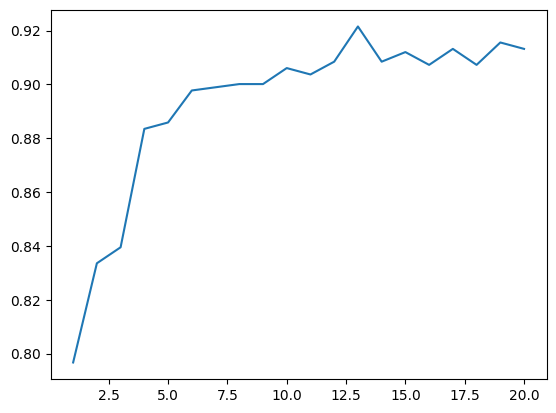

In [29]:
#CNN model train
import time
import matplotlib.pyplot as plt
%matplotlib inline

EPOCHS = 20 # epoch
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

accuracies_val = []
recalls_val = []
precisions_val = []
accuracies_train = []
recalls_train = []
precisions_train = []
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader, optimizer)
    accuracy_val, recall_val, precision_val = get_accuracy(valid_dataloader)
    accuracy_train, recall_train, precision_train = get_accuracy(train_dataloader)
    accuracies_val.append(accuracy_val)
    recalls_val.append(recall_val)
    precisions_val.append(precision_val)
    accuracies_train.append(accuracy_train)
    recalls_train.append(recall_train)
    precisions_train.append(precision_train)
    time_taken = time.time() - epoch_start_time
    print(f'''Epoch: {epoch}, time taken: {time_taken:.1f}s, validation accuracy: 
          {accuracy_val:.3f}, recall: {recall_val}, precision: {precision_val}.''')
    
plt.plot(range(1, EPOCHS+1), accuracies_val)

accuracy, recall, precision = get_accuracy(test_dataloader)
y, y_prob = get_probabilites(test_dataloader)
print(f'The estimated test accuracy is {accuracy:.3f}, recall {recall}, precision {precision}.')


In [30]:
accuracy, recall, precision = get_accuracy(test_dataloader)
y, y_prob = get_probabilites(test_dataloader)
print(f'The estimated test accuracy is {accuracy:.3f}, recall {recall}, precision {precision}.')

The estimated test accuracy is 0.909, recall 0.7706516981124878, precision 0.8079786896705627.


Text(0, 0.5, 'Accuracy')

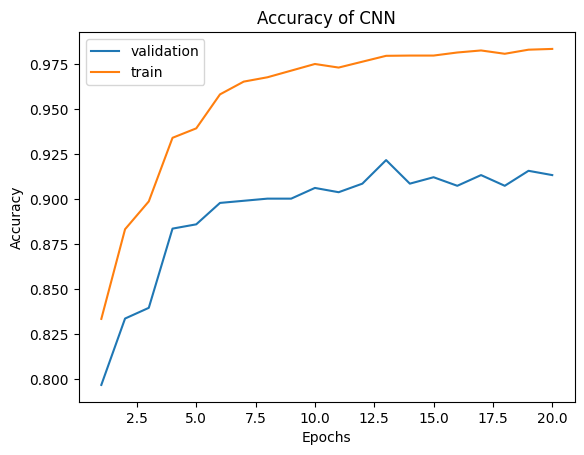

In [31]:
plt.plot(range(1, EPOCHS+1), accuracies_val, label='validation')
plt.plot(range(1, EPOCHS+1), accuracies_train, label='train')
plt.title('Accuracy of CNN')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


Text(0, 0.5, 'Recall')

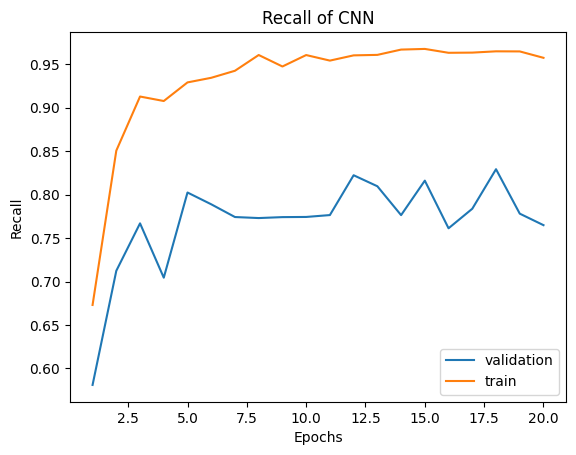

In [32]:
plt.plot(range(1, EPOCHS+1), recalls_val, label='validation')
plt.plot(range(1, EPOCHS+1), recalls_train, label='train')
plt.title('Recall of CNN')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Recall')


Text(0, 0.5, 'Precision')

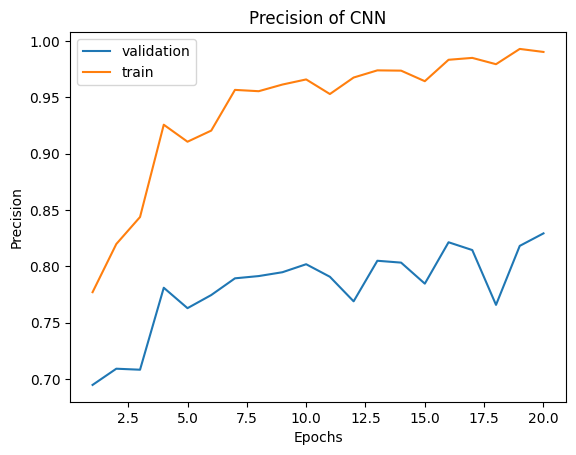

In [33]:
plt.plot(range(1, EPOCHS+1), precisions_val, label='validation')
plt.plot(range(1, EPOCHS+1), precisions_train, label='train')
plt.title('Precision of CNN')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Precision')


In [34]:
#roc curve

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')


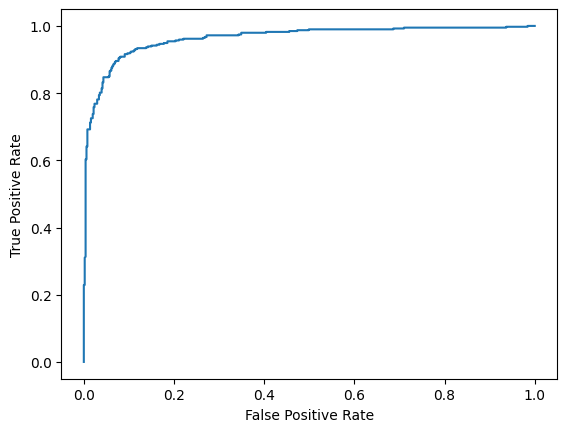

In [35]:
plot_roc_curve(y, y_prob)


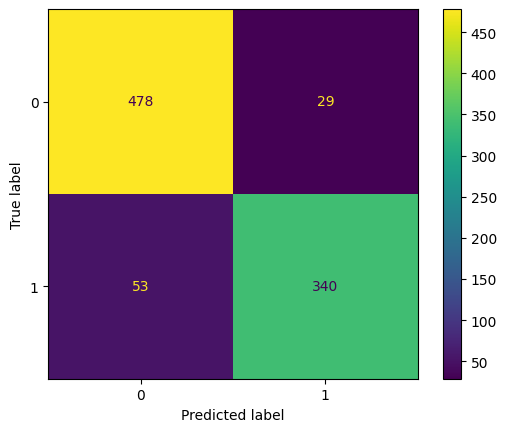

In [36]:
y_pred = [y.round() for y in y_prob]
cf_mat = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_mat)
disp.plot()
plt.show()


Evaluate model with increased dropout rate

In [44]:
model = CNNClassifier(embedding_dim = 300,
                 sequence_len = 500,
                 vocab_len = len(vocab), 
                 out_size = 32,
                 stride = 2,
                 dropout = 0.5,
                 glove_vectors=glove_vectors, 
                 use_glove = True,
                 freeze_glove = False)


In [45]:
BATCH_SIZE = 16

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE,
                              shuffle=True, 
                              collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE,
                              shuffle=False, 
                              collate_fn=collate_fn)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE,
                             shuffle=False, 
                             collate_fn=collate_fn)

At iteration 50 the loss is 21.866.
At iteration 100 the loss is 2.675.
At iteration 150 the loss is 19.306.
At iteration 200 the loss is 13.606.
At iteration 250 the loss is 19.050.
At iteration 300 the loss is 13.306.
At iteration 350 the loss is 24.295.
At iteration 400 the loss is 15.642.
Epoch: 1, time taken: 43.4s, validation accuracy: 
          0.843, recall: 0.658876359462738, precision: 0.714689314365387.
At iteration 50 the loss is 7.397.
At iteration 100 the loss is 9.908.
At iteration 150 the loss is 17.926.
At iteration 200 the loss is 24.346.
At iteration 250 the loss is 21.360.
At iteration 300 the loss is 24.271.
At iteration 350 the loss is 12.852.
At iteration 400 the loss is 15.475.
Epoch: 2, time taken: 43.7s, validation accuracy: 
          0.893, recall: 0.7981162667274475, precision: 0.7571555376052856.
At iteration 50 the loss is 12.537.
At iteration 100 the loss is 9.988.
At iteration 150 the loss is 15.540.
At iteration 200 the loss is 29.413.
At iteration 25

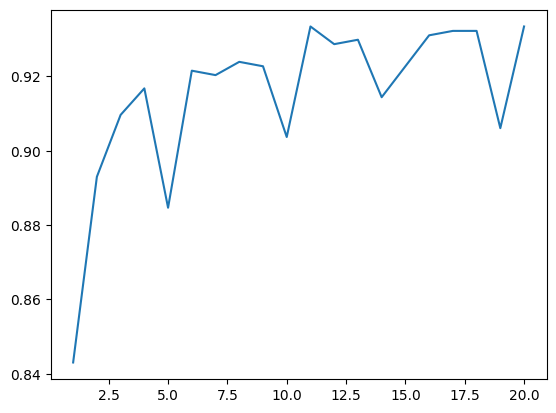

In [46]:
#CNN model train - 20 epochs with dropout of 0.5
%matplotlib inline

EPOCHS = 20 # epoch
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

accuracies_val = []
recalls_val = []
precisions_val = []
accuracies_train = []
recalls_train = []
precisions_train = []
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader, optimizer)
    accuracy_val, recall_val, precision_val = get_accuracy(valid_dataloader)
    accuracy_train, recall_train, precision_train = get_accuracy(train_dataloader)
    accuracies_val.append(accuracy_val)
    recalls_val.append(recall_val)
    precisions_val.append(precision_val)
    accuracies_train.append(accuracy_train)
    recalls_train.append(recall_train)
    precisions_train.append(precision_train)
    time_taken = time.time() - epoch_start_time
    print(f'''Epoch: {epoch}, time taken: {time_taken:.1f}s, validation accuracy: 
          {accuracy_val:.3f}, recall: {recall_val}, precision: {precision_val}.''')
    
plt.plot(range(1, EPOCHS+1), accuracies_val)

accuracy, recall, precision = get_accuracy(test_dataloader)
y, y_prob = get_probabilites(test_dataloader)
print(f'The estimated test accuracy is {accuracy:.3f}, recall {recall}, precision {precision}.')


Text(0, 0.5, 'Accuracy')

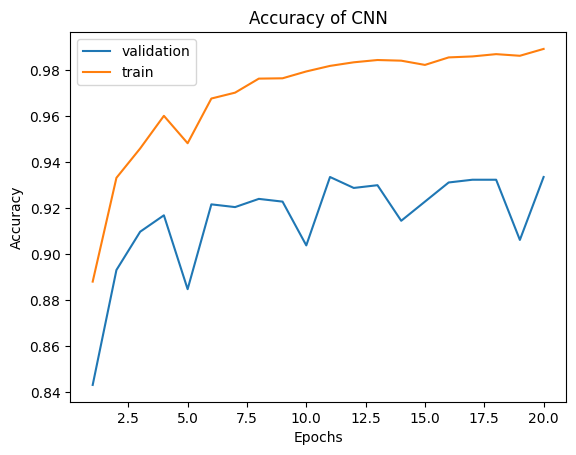

In [47]:
plt.plot(range(1, EPOCHS+1), accuracies_val, label='validation')
plt.plot(range(1, EPOCHS+1), accuracies_train, label='train')
plt.title('Accuracy of CNN')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


Text(0, 0.5, 'Recall')

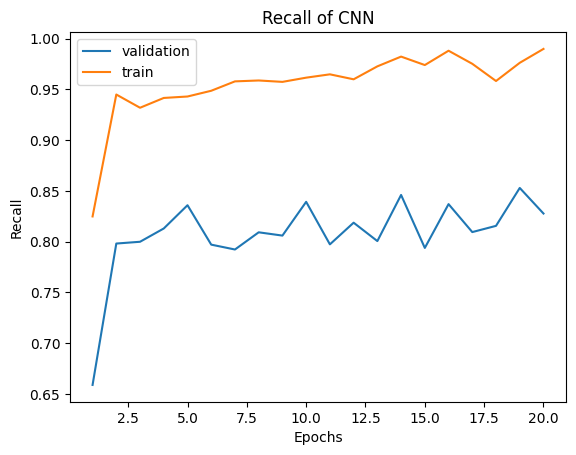

In [48]:
plt.plot(range(1, EPOCHS+1), recalls_val, label='validation')
plt.plot(range(1, EPOCHS+1), recalls_train, label='train')
plt.title('Recall of CNN')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Recall')


Text(0, 0.5, 'Precision')

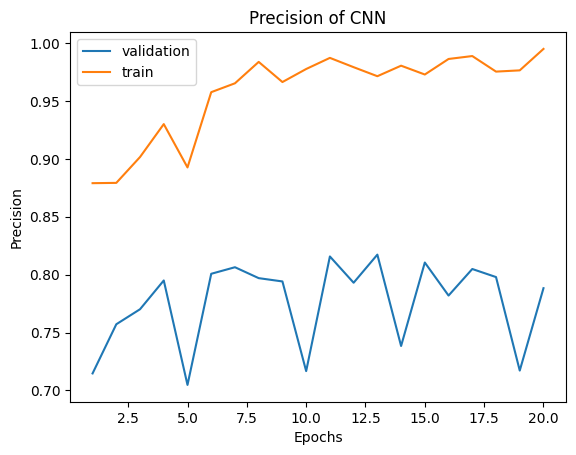

In [49]:
plt.plot(range(1, EPOCHS+1), precisions_val, label='validation')
plt.plot(range(1, EPOCHS+1), precisions_train, label='train')
plt.title('Precision of CNN')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Precision')


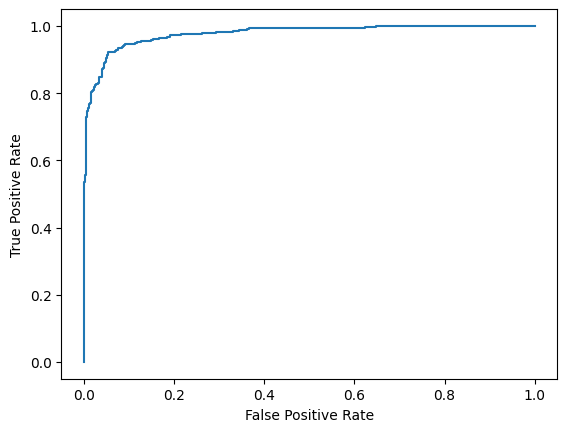

In [50]:
plot_roc_curve(y, y_prob)


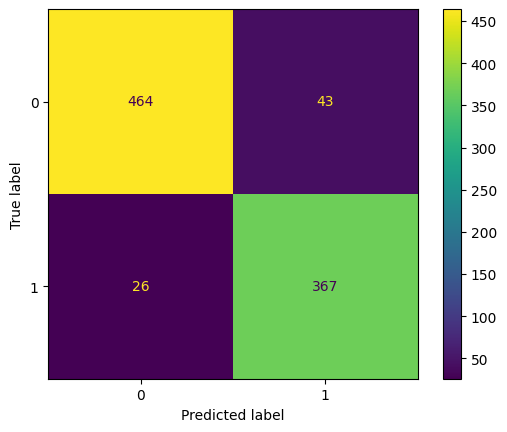

In [51]:
y_pred = [y.round() for y in y_prob]
cf_mat = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_mat)
disp.plot()
plt.show()